# Variational inference of latent state in state-space models  

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import torch

from scipy.special import roots_hermite
from scipy.stats import norm

import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve


## Core ideas

### State space model

State transition:
$$p(x_{t+1}|x_t)$$

Observation: 
$$p(y_t|x_t)$$

State trajectory distribution:
$$p(x_{0:T})=p(x_0,x_1,x_2,...x_T)=p(x_0)p(x_1|x_0)p(x_2|x_1)...p(x_T|x_{T-1})$$

Parameter vector $\theta$ for both state transition and observation distributions.

=> Find a posterior distribution 

$$p(x_{0:T},\theta|y_{1:T})$$

### Variational Inference
Approximate the posterior by

$$q(x_{0:T}, \theta)$$

such that the KL divergence between the posterior and the approximation is minimized.

$$q^*(x_{0:T},\theta)=\underset{q(x_{0:T},\theta)}{\operatorname{argmin}}KL(q(x_{0:T},\theta)||p(x_{0:T},\theta|y_{1:T}))$$

Here, 

$$q(x_{0:T},\theta)=\prod_{t=0}^T q(x_t)\delta(\theta)$$

where $\delta$ is the Dirac delta function. Roughly, with degenerate 'uniform' prior for $\theta$, $p(\theta)=C$ and independence between state and parameter prior,
$$p(x_{0:T},\theta)=p(x_{0:T})p(\theta),$$
this implies that we are looking for a MAP point estimate for $\theta$. Now,

$$\begin{aligned} 
KL(q(x_{0:T},\theta)||p(x_{0:T},\theta|y_{1:T})) &=\int q(x_{0:T},\theta)\log\frac{q(x_{0:T},\theta)}{p(x_{0:T},\theta|y_{1:T})}d\theta dx_{0:T}\\
&=\int q(x_{0:T},\theta)\log\frac{q(x_{0:T},\theta)p(y_{1:T})}{p(x_{0:T},\theta,y_{1:T})}d\theta dx_{0:T}\\
&=\int q(x_{0:T},\theta)\log\frac{q(x_{0:T},\theta)}{p(x_{0:T},\theta,y_{1:T})}d\theta dx_{0:T}+\int q(x_{0:T},\theta)\log p(y_{1:T})d\theta dx_{0:T}\\
&=\int q(x_{0:T},\theta)\log\frac{q(x_{0:T},\theta)}{p(x_{0:T},\theta)p(y_{1:T}|x_{0:T},\theta)}d\theta dx_{0:T}+\log p(y_{1:T})\\
&=\int q(x_{0:T},\theta)\log\frac{q(x_{0:T},\theta)}{p(x_{0:T},\theta)}d\theta dx_{0:T}-\int q(x_{0:T},\theta)\log p(y_{1:T}|x_{0:T},\theta)d\theta dx_{0:T}+\log p(y_{1:T})\\
&=KL(q(x_{0:T},\theta)||p(x_{0:T},\theta))-\mathbb{E}_{q(x_{0:T},\theta)}[\log p(y_{1:T}|x_{0:T},\theta)]+\log p(y_{1:T})\\
&=KL(q(x_{0:T})\delta(\theta)||p(x_{0:T})p(\theta))-\mathbb{E}_{q(x_{0:T},\theta)}[\log p(y_{1:T}|x_{0:T},\theta)]+\text{const}\\
&=KL(q(x_{0:T})||p(x_{0:T}))+KL(\delta(\theta)||p(\theta))-\mathbb{E}_{q(x_{0:T},\theta)}[\log p(y_{1:T}|x_{0:T},\theta)]+\text{const}\\
&=KL(q(x_{0:T})||p(x_{0:T}))+\text{const}-\mathbb{E}_{q(x_{0:T},\theta)}[\log p(y_{1:T}|x_{0:T},\theta)]+\text{const}\\
\end{aligned}$$

Minimizing the KL divergence is equivalent to maximizing the ELBO (evidence lower bound) with respect to $q(x_{0:T})$ and $\theta$:

$$\text{ELBO}=\mathbb{E}_{q(x_{0:T},\theta)}[\log p(y_{1:T}|x_{0:T},\theta)]-KL(q(x_{0:T})||p(x_{0:T}))$$

Given our choice of $q(x_{0:T},\theta)$, the ELBO can be simplified to

$$\text{ELBO}=\mathbb{E}_{q(x_{0:T})}[\log p(y_{1:T}|x_{0:T},\theta)]-KL(\prod_{t=0}^T q(x_t)||p(x_0)p(x_1|x_0)p(x_2|x_1)...p(x_T|x_{T-1}))$$

$$=\mathbb{E}_{q(x_{0:T})}[\log p(y_{1:T}|x_{0:T},\theta)]-KL(q(x_0)||p(x_0))-\sum_{t=1}^T\int q(x_t,x_{t-1}) \log\frac{q(x_t)}{p(x_t|x_{t-1})}dx_tdx_{t-1}$$

The last term can be written as follows:

$$\begin{aligned}
\int q(x_t,x_{t-1}) \log\frac{q(x_t)}{p(x_t|x_{t-1})}dx_tdx_{t-1} &= \int q(x_t,x_{t-1})\log q(x_t)dx_tdx_{t-1}-\int q(x_t,x_{t-1})\log p(x_t|x_{t-1})dx_tdx_{t-1}\\
&= \int q(x_t)\log q(x_t)dx_t-\int q(x_t)q(x_{t-1})\log p(x_t|x_{t-1})dx_tdx_{t-1}\\
\end{aligned}
$$

Now, we are stuck with $\int q(x_t) q(x_{t-1})\log p(x_t|x_{t-1})dx_tdx_{t-1}$. 

For specific cases of $q(x_t)$, $q(x_{t-1})$ and $p(x_t|x_{t-1})$, we can solve. 

## Gaussian state-space model
Consider a Gaussian State transition and Gaussian variational distributions:

$$\begin{aligned}
    p(x_t|x_{t-1}) &= \mathcal{N}(x_t;\mu  + Ax_{t-1},\Sigma)\\
    q(x_t)&=\mathcal{N}(x_t;m_t,S_t) \forall t\\
\end{aligned}$$

This allows to simplify as follows:

$$\begin{aligned}
\int q(x_t) q(x_{t-1})\log p(x_t|x_{t-1})dx_tdx_{t-1} &= \int q(x_t) \int q(x_{t-1})\log p(x_t|x_{t-1})dx_{t-1}dx_t \\
&= \int \mathcal{N}(x_t;m_t,S_t) \int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})\log \mathcal{N}(x_t;\mu  + Ax_{t-1},\Sigma)dx_{t-1}dx_t \\  
&= \int \mathcal{N}(x_t;m_t,S_t) \int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})\left[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma|-\frac{1}{2}(x_t-\mu-Ax_{t-1})^T\Sigma^{-1}(x_t-\mu-Ax_{t-1})\right]dx_{t-1}dx_t \\ 
&= \int \mathcal{N}(x_t;m_t,S_t) \left[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma|\right]-\frac{1}{2}\int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})\left[(x_t-\mu-Ax_{t-1})^T\Sigma^{-1}(x_t-\mu-Ax_{t-1})\right]dx_{t-1}dx_t \\ 
&= \int \mathcal{N}(x_t;m_t,S_t) \left[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma|\right]-\frac{1}{2}\int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})\left[(x_t-\mu-Ax_{t-1})^T\Sigma^{-1}(x_t-\mu-Ax_{t-1})\right]dx_{t-1}dx_t \\ 
&= \int \mathcal{N}(x_t;m_t,S_t) \left[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma|\right] \\
&\quad-\frac{1}{2}\int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})\left[x_t^T\Sigma^{-1}x_t +\mu^T\Sigma^{-1}\mu + x_{t-1}^TA^T\Sigma^{-1}Ax_{t-1}-2x_t^T\Sigma^{-1} \mu - 2x_t^T\Sigma^{-1} Ax_{t-1} + 2\mu^T\Sigma^{-1}Ax_{t-1}\right]dx_{t-1}dx_t \\
&= \int \mathcal{N}(x_t;m_t,S_t) \left[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma|\right] \\
&\quad-\frac{1}{2}\left[x_t^T\Sigma^{-1}x_t +\mu^T\Sigma^{-1}\mu -2x_t^T\Sigma^{-1} \mu +\int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})\left[x_{t-1}^TA^T\Sigma^{-1}Ax_{t-1} - 2x_t^T\Sigma^{-1} Ax_{t-1} + 2\mu^T\Sigma^{-1}Ax_{t-1}\right]dx_{t-1}\right]dx_t\\
&= \int \mathcal{N}(x_t;m_t,S_t) \left[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma|\right] \\
&\quad-\frac{1}{2}\left[x_t^T\Sigma^{-1}x_t +\mu^T\Sigma^{-1}\mu -2x_t^T\Sigma^{-1} \mu - 2x_t^T\Sigma^{-1} Am_{t-1} + 2\mu^T\Sigma^{-1}Am_{t-1}+\int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})x_{t-1}^TA^T\Sigma^{-1}Ax_{t-1}dx_{t-1}\right]dx_t\\
&= \int \mathcal{N}(x_t;m_t,S_t) \Bigg[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma| \\
&\quad-\frac{1}{2}\left[x_t^T\Sigma^{-1}x_t +\mu^T\Sigma^{-1}\mu -2x_t^T\Sigma^{-1} \mu - 2x_t^T\Sigma^{-1} Am_{t-1} + 2\mu^T\Sigma^{-1}Am_{t-1}+\int \mathcal{N}(x_{t-1};m_{t-1},S_{t-1})x_{t-1}^TA^TL^{-1}(L^{-1})^TAx_{t-1}dx_{t-1}\right]\Bigg]dx_t \\
&= \int \mathcal{N}(x_t;m_t,S_t) \Bigg[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma| \\
&\quad-\frac{1}{2}\left[x_t^T\Sigma^{-1}x_t +\mu^T\Sigma^{-1}\mu -2x_t^T\Sigma^{-1} \mu - 2x_t^T\Sigma^{-1} Am_{t-1} + 2\mu^T\Sigma^{-1}Am_{t-1}+\int \mathcal{N}(\tilde{x}_{t-1};(L^{-1})^T Am_{t-1},(L^{-1})^T AS_{t-1}A^T L^{-1})\tilde{x}_{t-1}^T \tilde{x}_{t-1}\right]\Bigg]dx_t \\
&= \int \mathcal{N}(x_t;m_t,S_t) \Bigg[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma| \\
&\quad-\frac{1}{2}\left[x_t^T\Sigma^{-1}x_t +\mu^T\Sigma^{-1}\mu -2x_t^T\Sigma^{-1} \mu - 2x_t^T\Sigma^{-1} Am_{t-1} + 2\mu^T\Sigma^{-1}Am_{t-1}+m_{t-1}^TA^TL^{-1}(L^{-1})^T Am_{t-1}+tr((L^{-1})^T AS_{t-1}A^T L^{-1})\right]\Bigg]dx_t \\
&= \int \mathcal{N}(x_t;m_t,S_t) \Bigg[-\frac{d}{2}\log(2\pi) -\frac{1}{2}\log|\Sigma| \\
&\quad-\frac{1}{2}\left[(x_t-\mu-Am_{t-1})^T\Sigma^{-1}(x_t-\mu-Am_{t-1})+tr((L^{-1})^T AS_{t-1}A^T L^{-1})\right]\Bigg]dx_t \\
&= \int\mathcal{N}(x_t;m_t,S_t) \log\mathcal{N}(x_t;\mu+Am_{t-1},\Sigma) dx_t -\frac{1}{2} tr((L^{-1})^T AS_{t-1}A^T L^{-1})\\
&= \int q(x_t) \log\mathcal{N}(x_t;\mu+Am_{t-1},\Sigma) dx_t - \frac{1}{2}tr((L^{-1})^T AS_{t-1}A^T L^{-1})
\end{aligned}$$

Plugging back in, we get

$$\begin{aligned}
\int q(x_t)\log q(x_t)dx_t-\int q(x_t)q(x_{t-1})\log p(x_t|x_{t-1})dx_tdx_{t-1} &= \int q(x_t)\log q(x_t)dx_t- \int q(x_t) \log\mathcal{N}(x_t;\mu+Am_{t-1},\Sigma) dx_t + \frac{1}{2} tr((L^{-1})^T AS_{t-1}A^T L^{-1}) \\
&= KL(q(x_t)||\mathcal{N}(x_t;\mu+Am_{t-1},\Sigma)) + \frac{1}{2}tr((L^{-1})^T AS_{t-1}A^T L^{-1})
\end{aligned}$$

And thus, for the ELBO:

$$ELBO=\mathbb{E}_{q(x_{0:T})}[\log p(y_{1:T}|x_{0:T},\theta)]-KL(q(x_0)||p(x_0))-\sum_{t=1}^T KL(q(x_t)||\mathcal{N}(x_t;\mu+Am_{t-1},\Sigma)) - \frac{1}{2}tr((L^{-1})^T AS_{t-1}A^T L^{-1})$$

Therefore, we can propagate the variational Gaussian distribution $q(x_{t-1})$ through $p(x_t|x_{t-1})$ and marginalize the joint distribution. Then we can compute the KL divergence with $q_{t}$ and add the correcting trace term.

The log-likelihood term can, depending on the  either be computed analytically, approximated by sampling from $q(x_{0:T})$ or by using Gaussian quadrature. 

For a single dimensional, Gaussian state, quadrature is useful if the state-likelihood relation is non-Gaussian. E.g. for the stochastic volatility model, we have:

$$\begin{aligned}
p(x_t|x_{t-1}) &= \mathcal{N}(x_t;x_{t-1},\sigma^2)\\
p(y_t|x_t) &= \mathcal{N}(y_t;\mu,\exp(x_t))
\end{aligned}$$

Rewrite the state-transition as follows:
$$
\begin{aligned}
p(x_t|x_{t-1}) &= \mathcal{N}(x_t;x_{t-1}),\sigma^2)\\
&= \mathcal{N}(x_t;0+1\cdot x_{t-1},\sigma^2)\\
\end{aligned}
$$

With $q(x_{t-1})=\mathcal{N}(x_{t-1};m_{t-1},s_{t-1}^2)$, the ELBO is then:

$$\begin{aligned}
ELBO &= \mathbb{E}_{q(x_{0:T})}[\log p(y_{1:T}|x_{0:T},\theta)]-KL(q(x_0)||p(x_0))-\sum_{t=1}^T KL(q(x_t)||\mathcal{N}(x_t;m_{t-1},\sigma^2)) - \frac{1}{2}\frac{s_{t-1}^2}{\sigma^2} \\
\end{aligned}
$$

In [2]:
class VariationalSVM:

    def __init__(self, T_train, hermite_order=10):
        self.T_train = T_train

        self.mu_variational = torch.nn.Parameter(torch.randn(T_train+1)*0.1 - 3, requires_grad=True)
        self.sigma_variational = torch.nn.Parameter(torch.randn(T_train+1)*0.1+np.log(0.1), requires_grad=True)

        self.init_mu = torch.nn.Parameter(torch.tensor(0.0)-3, requires_grad=True)
        self.init_sigma = torch.nn.Parameter(torch.tensor(np.log(0.1)), requires_grad=True)

        self.obs_mu = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.sv_sigma = torch.nn.Parameter(torch.tensor(np.log(0.1)), requires_grad=True)
        
        self.hermite_roots = torch.tensor(roots_hermite(hermite_order)[0]).reshape(1,-1)
        self.hermite_weights = torch.tensor(roots_hermite(hermite_order)[1]).reshape(1,-1)

    def fit(self, y, epochs=3000, lr=0.01):
        parameters = [self.mu_variational, self.sigma_variational, self.obs_mu, self.sv_sigma, self.init_mu, self.init_sigma]

        y_torch = torch.tensor(y, dtype=torch.float32)

        optimizer = torch.optim.RMSprop(parameters, lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = -self.elbo(y_torch)
            loss.backward()
            optimizer.step()
            if epoch % 300 == 0:
                print(f"Epoch {epoch}: {loss}")

    def elbo(self, y):
        return (self.observation_likelihood(y) - self.state_kldiv() - self._kl_regularizer().sum())/ len(y)
    
    def state_kldiv(self):
        mu, sigma = self._forward_states(self.mu_variational[:-1])
        obs_state_kldiv = torch.sum(self._gaussian_kl_divergence(self.mu_variational[1:], torch.exp(self.sigma_variational[1:]),mu, sigma))
        init_state_kldiv = torch.sum(self._gaussian_kl_divergence(self.mu_variational[0], torch.exp(self.sigma_variational[0]), self.init_mu, torch.exp(self.init_sigma)))
        return obs_state_kldiv + init_state_kldiv
    
    def observation_likelihood(self, y):
        mu, sigma = self.mu_variational[1:], torch.exp(self.sigma_variational[1:])

        roots, weights = self.hermite_roots, self.hermite_weights
        scaled_roots = mu.reshape(-1,1) + roots * sigma.reshape(-1,1) * torch.sqrt(torch.tensor(2.0))

        dists = torch.distributions.Normal(self.obs_mu, torch.exp(scaled_roots)**0.5)
        return 1.0 / np.sqrt(3.14) * torch.sum(weights * dists.log_prob(y.reshape(-1,1)), dim=1).sum()

    def _gaussian_kl_divergence(self, mu_1, sigma_1, mu_2, sigma_2):
        return torch.log(sigma_2) - torch.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*sigma_2**2) - 0.5
    
    def _kl_regularizer(self):
        return 0.5*torch.exp(self.sigma_variational[:-1])**2 / torch.exp(self.sv_sigma)**2
    
    
    def _forward_states(self, x):
        return x, torch.exp(self.sv_sigma) *torch.ones(x.shape)
    



Compare on [Pyro Example for StochasticVolatility](https://pyro.ai/examples/stable.html); replace Stable distribution by normal distribution.



In [3]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()

r = (x[1:] / x[:-1]).log()[-500:] #only last 500 observations for speed and plottability

In [4]:
model = VariationalSVM(len(r))
model.fit(r, epochs=15000, lr=0.001)

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_49291/2222375426.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_torch = torch.tensor(y, dtype=torch.float32)


Epoch 0: 0.9661878450124246
Epoch 300: -0.25772427164926776
Epoch 600: -0.3492321266632049
Epoch 900: -0.490342730062777
Epoch 1200: -0.6414933041441354
Epoch 1500: -0.7935682951510592
Epoch 1800: -0.9452671538808363
Epoch 2100: -1.0963834713273448
Epoch 2400: -1.2466895941779013
Epoch 2700: -1.3956334504677272
Epoch 3000: -1.5422422327834961
Epoch 3300: -1.6860244318064324
Epoch 3600: -1.8277915821867003
Epoch 3900: -1.9672784887932344
Epoch 4200: -2.103803925148078
Epoch 4500: -2.2365100414646877
Epoch 4800: -2.3643368811629832
Epoch 5100: -2.486012826973618
Epoch 5400: -2.600165490082849
Epoch 5700: -2.705465957453146
Epoch 6000: -2.8008147693329484
Epoch 6300: -2.885494463111968
Epoch 6600: -2.9591203817006964
Epoch 6900: -3.0213672354173498
Epoch 7200: -3.072042840896504
Epoch 7500: -3.111557517459218
Epoch 7800: -3.1409610170015227
Epoch 8100: -3.1616046141000527
Epoch 8400: -3.175030289443991
Epoch 8700: -3.18284216999581
Epoch 9000: -3.1867202404968555
Epoch 9300: -3.1884403630

In [5]:
def pyro_model(data):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(data.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    pyro.sample("r", dist.Normal(r_loc, sqrt_h).to_event(1),
                obs=data)
    
reparam_model = poutine.reparam(pyro_model, {"v": DiscreteCosineReparam()})

pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1001
optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))


step 0 loss = 3.90561
step 50 loss = -1.45567
step 100 loss = -2.1139
step 150 loss = -2.66966
step 200 loss = -2.9662
step 250 loss = -2.8784
step 300 loss = -3.08116
step 350 loss = -2.98767
step 400 loss = -2.99272
step 450 loss = -3.07573
step 500 loss = -3.27141
step 550 loss = -3.23652
step 600 loss = -3.23926
step 650 loss = -3.20532
step 700 loss = -3.10074
step 750 loss = -3.25319
step 800 loss = -3.23684
step 850 loss = -3.27558
step 900 loss = -3.16651
step 950 loss = -3.27998
step 1000 loss = -3.26519


In [6]:
vari_means = model.mu_variational.detach().numpy()
vari_stds = np.exp(model.sigma_variational.detach().numpy())

means = vari_means[1:] 
lower_95 = norm.ppf(0.025, loc=vari_means[1:], scale=vari_stds[1:])
upper_95 = norm.ppf(0.975, loc=vari_means[1:], scale=vari_stds[1:])

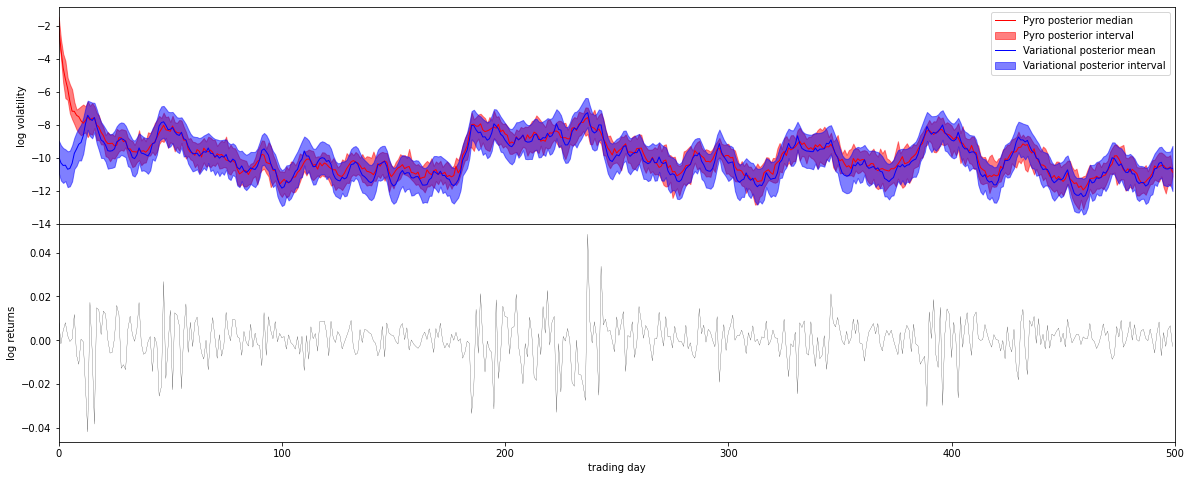

In [7]:
fig, axes = pyplot.subplots(2, figsize=(20, 8), sharex=True)
pyplot.subplots_adjust(hspace=0)
axes[1].plot(r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=20, parallel=True)(r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1, color="red", label="Pyro posterior median")

axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(2, dim=0).values,
                     log_h.kthvalue(18, dim=0).values,
                     color='red', alpha=0.5, label="Pyro posterior interval")
axes[0].plot(means, lw=1, color="blue", label="Variational posterior mean")
axes[0].fill_between(torch.arange(len(log_h[0])),
                     lower_95,
                     upper_95,
                     color='blue', alpha=0.5, label="Variational posterior interval")
axes[0].set_ylabel("log volatility")
axes[0].legend()


axes[1].set_xlabel("trading day");

## Hidden Markov Model
Next, consider a Hidden Markov Model with $S$ states and Gaussian Observations:

$$
\begin{aligned}
p(x_t=j|x_{t-1}=i)&=A_{ij}\\
p(y_t|x_t) &= \prod_{j=1}^S \mathcal{N}(y_t;\mu_j,\sigma^2_j)^{I(x_t=j)}
\end{aligned}
$$

where $A$ denotes the transition matrix of the latent, discrete valued Markov Chain.

The $x_t$ we want to infer now take on discrete values in $\{1,...,S\}$. Let's use independent, categorical variational distributions:

$$q(x_0,...,x_T)=\prod_{t=0}^T\prod_{j=1}^S (q^{(t)}_j)^{I(x_t=j)}$$

Then, the $\mathbb{E}_{q(x_{0:T})}[\log p(y_{1:T}|x_{0:T},\theta)]$ term is a sum of sums of weighted log-likelihoods (the weights are the $q(x^{(t)}_j)$).

Due to the discreteness of $q(x_t)$, the term

$$\int q(x_t,x_{t-1}) \log\frac{q(x_t)}{p(x_t|x_{t-1})}dx_tdx_{t-1}$$

becomes a sum (leaving potential measure theoretic complications aside):

$$\sum_{j=1}^S\sum_{i=1}^S q(x_t=j,x_{t-1}=i) \log\frac{q(x_t=j)}{p(x_t=j|x_{t-1}=i)}$$

Using independence of the variational distribution:

$$\begin{aligned}
\sum_{j=1}^S\sum_{i=1}^S q(x_t=j)q(x_{t-1}=i) \log\frac{q(x_t=j)}{p(x_t=j|x_{t-1}=i)} &=\sum_{j=1}^S\sum_{i=1}^S q(x_t=j)q(x_{t-1}=i) \log\frac{q(x_t=j)}{p(x_t=j|x_{t-1}=i)}
\end{aligned}
$$

This can directly be calculated without further complications.

In [8]:
class VariationalHMM:

    def __init__(self, T_train, N_states = 3):
        self.T_train = T_train

        self.variational = torch.nn.Parameter(torch.randn(T_train+1, N_states)*0.1, requires_grad=True)

        self.obs_mu = torch.nn.Parameter(torch.randn(N_states).reshape(1,-1), requires_grad=True)
        self.obs_sigma = torch.nn.Parameter(torch.randn(N_states).reshape(1,-1)*0.1+np.log(0.1), requires_grad=True)

        self.transition_probs = torch.nn.Parameter(torch.randn(N_states, N_states)*0.1, requires_grad=True)
        self.initial_probs = torch.nn.Parameter(torch.randn(N_states)*0.1, requires_grad=True)


    def fit(self, y, epochs=3000, lr=0.01):
        parameters = [self.variational, self.obs_mu, self.obs_sigma, self.transition_probs, self.initial_probs]

        y_torch = torch.tensor(y, dtype=torch.float32)

        optimizer = torch.optim.Adam(parameters, lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = -self.elbo(y_torch)
            loss.backward()
            optimizer.step()
            if epoch % 300 == 0:
                print(f"Epoch {epoch}: {loss}")

    def elbo(self, y):
        return (self.observation_likelihood(y) - self.state_kldiv())/ len(y)
    
    def state_kldiv(self):
        P = torch.softmax(self.variational, dim=1)
        transition_kldivs = torch.sum(self._categorical_kl_divergence(P[1:,:], torch.exp(self._forward_states(P[:-1,:]))))

        initial_probs = torch.softmax(self.initial_probs, dim=0)
        init_kldiv = self._categorical_kl_divergence(P[0,:], initial_probs)
        
        return init_kldiv + transition_kldivs
    
    def observation_likelihood(self, y):
        P = torch.softmax(self.variational[1:,:], dim=1)
        mu, sigma = self.obs_mu, torch.exp(self.obs_sigma)

        dists = torch.distributions.Normal(mu, sigma)
        return torch.sum(P * dists.log_prob(y.reshape(-1,1)), dim=1).sum()

    def _categorical_kl_divergence(self, q, p):
        return torch.sum(q * (torch.log(q) - torch.log(p)))
    
    
    def _forward_states(self, P):
        return P@torch.log(torch.softmax(self.transition_probs, dim=1))
    



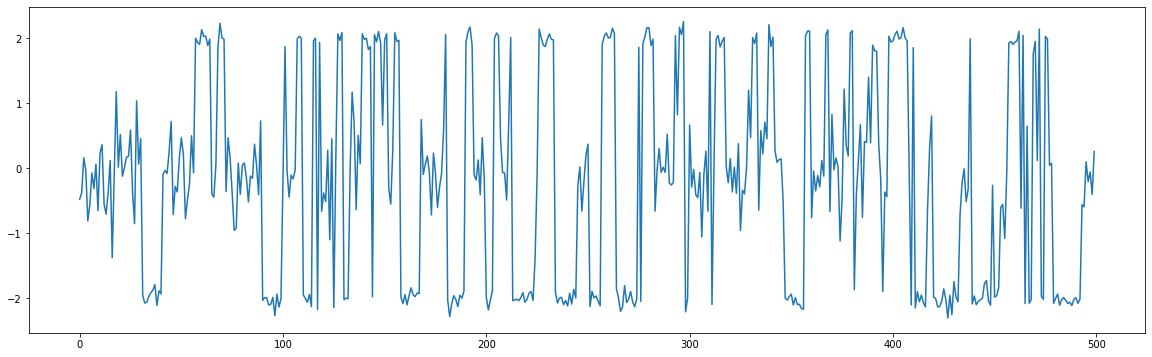

In [9]:
np.random.seed(123)

state_mus = [-2., 0., 2.]
state_sigmas = [0.1, 0.5, 0.1]

hmm_transition_probs = np.array([  [0.8, 0.1, 0.1],
                                      [0.1, 0.8, 0.1],
                                      [0.15, 0.15, 0.7]])

hmm_initial_probs = np.array([0.0, 1.0, 0.0])

states = [np.random.choice([0,1,2], p=hmm_initial_probs)]
obs = [np.random.normal(state_mus[states[-1]], state_sigmas[states[-1]])]

N = 500

for _ in range(N-1):
    states.append(np.random.choice([0,1,2], p=hmm_transition_probs[states[-1]]))
    obs.append(np.random.normal(state_mus[states[-1]], state_sigmas[states[-1]]))

plt.figure(figsize=(20,6))
plt.plot(obs)

In [10]:
model = VariationalHMM(N)
model.fit(obs, epochs=12000, lr=0.01)

Epoch 0: 111.38201141357422
Epoch 300: 3.8468854427337646
Epoch 600: 1.7694669961929321
Epoch 900: 1.3387870788574219
Epoch 1200: 1.1920726299285889
Epoch 1500: 1.1000003814697266
Epoch 1800: 1.0296285152435303
Epoch 2100: 0.9590142965316772
Epoch 2400: 0.8850977420806885
Epoch 2700: 0.8049094080924988
Epoch 3000: 0.7211445569992065
Epoch 3300: 0.6353932619094849
Epoch 3600: 0.5591513514518738
Epoch 3900: 0.504254937171936
Epoch 4200: 0.4723905324935913
Epoch 4500: 0.45653876662254333
Epoch 4800: 0.448551207780838
Epoch 5100: 0.4439469873905182
Epoch 5400: 0.4409642219543457
Epoch 5700: 0.4388900101184845
Epoch 6000: 0.43737879395484924
Epoch 6300: 0.4362398087978363
Epoch 6600: 0.435359388589859
Epoch 6900: 0.4346652030944824
Epoch 7200: 0.4341092109680176
Epoch 7500: 0.4336581826210022
Epoch 7800: 0.43328917026519775
Epoch 8100: 0.4329846203327179
Epoch 8400: 0.4327313303947449
Epoch 8700: 0.4325278401374817
Epoch 9000: 0.4323424696922302
Epoch 9300: 0.43219470977783203
Epoch 9600: 0

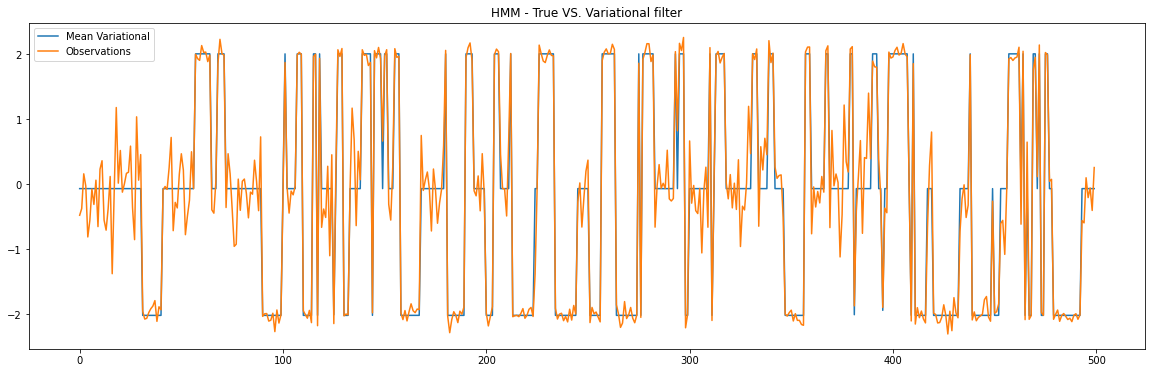

In [11]:
variational = torch.softmax(model.variational.detach()[1:,:], dim=1).numpy()
means = np.sum(variational * model.obs_mu.detach().numpy(),axis=1)

plt.figure(figsize=(20,6))
plt.title("HMM - True VS. Variational filter")
plt.plot(means, label="Mean Variational")
plt.plot(obs, label="Observations")
plt.legend()

In [12]:
np.round(torch.softmax(model.transition_probs, dim=1).detach().numpy(),3)

array([[0.82 , 0.075, 0.105],
       [0.145, 0.684, 0.171],
       [0.054, 0.113, 0.834]], dtype=float32)

In [13]:
hmm_transition_probs

array([[0.8 , 0.1 , 0.1 ],
       [0.1 , 0.8 , 0.1 ],
       [0.15, 0.15, 0.7 ]])